## 1. Business and Data Understanding

The Academy Awards are the most respected recognition within the film industry. Movie studios seek to win these awards because it can bring additional business and help with acquiring talent. The Oscar for Best Picture is the most coveted.

The goal of this project is to discover similarties between films that won best picture, while also identifying differences between films that were only nominted and those that won. This will be done using the tools we've covered in class: descriptive analytics, topic modeling, sentiment analysis, and network analysis.

Data will be collected from IMDB and Rotten Tomatoes using web crawling, and data from Twitter will be collected via API. Movies nominated for best picture from 2011 - 2021 will be included in this analysis.

The characteristics discovered in this analysis using the techniques above will allow insight into potential strategies for studios developing films with the intention of winning Best Picture.

In [1]:
# import needed packages
import requests
from lxml import html
import csv
import pandas as pd
import re
import json
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud, STOPWORDS

# for sentiment analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# text processing
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re

# topic modeling
import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# graphing
import seaborn as sns

# show images
from IPython.display import Image
from IPython.core.display import HTML 

# suppress error messages
import warnings
warnings.filterwarnings('ignore')

# set column widths to 300
pd.set_option('display.max_colwidth', 300)

# display all columns in dataframes
pd.set_option('display.max_columns', None)

## 2. Data Identification and Collection

Data from IMDB and Rotten Tomaoes will be gathered via scraping and crawling. Data from Twitter will be gathered via API.

IMDB data will be used in network analysis.

Rotten Tomatoes and Twitter data will be used in content analysis.

### Web Crawling Current Nominees

#### Crawl IMDB for Best Picture Nomination URLs
Data will be used to crawl IMDB to create the actor list.

1. Title
2. Short url
3. Year
4. Winner flag

In [21]:
# create empty list
stuff = []

# base url for craling
web = "https://www.imdb.com/event/ev0000003/%s/1"

# for years 2011 - 2021
for page in range(2011,2022):
    url = web % page
    winner = 1 # the first movie listed is always the winner
    response = requests.get(url).text
    
    # get correct json data
    data = json.loads(re.findall(r'IMDbReactWidgets\.NomineesWidget\.push.*?(\{.*\})', response)[0])
    newstuff = data['nomineesWidgetModel']['eventEditionSummary']['awards'] # traverse to appropriate pathway
    for i in newstuff[0]['categories'][0]['nominations']: # for each nomination
        if page == 2021: # this data was pulled prior to the 2021 oscars, so no winner had been selected
            winner = ''  # all 2021 winners will be listed as blank
        # append movie title, short url, year of nomination, and winner flag to empty list
        stuff.append([i['primaryNominees'][0]['name'], i['primaryNominees'][0]['const'], page, winner])
        # reset winner for 2nd+ movies in json data
        winner = 0

In [22]:
# convert to data frame
imdb_df = pd.DataFrame(stuff)
# rename columns
imdb_df = imdb_df.rename(columns={0: 'title', 1: 'short_url', 2: 'year', 3:'winner'})
imdb_df.head(2)

,title,short_url,year,winner
0,The King's Speech,tt1504320,2011,1
1,127 Hours,tt1542344,2011,0


In [23]:
# store full url in datafram
imdb_df['full_url'] = 'https://www.imdb.com/title/' + imdb_df['short_url']

In [24]:
# save to csv
imdb_df.to_csv('imdb_details.csv')

#### Crawl Best Picture Data From IMDB
Data will be used to crawl IMDB for the actor network.

1. Actor name
2. Cast list position
3. Actor short url
4. Movie url

In [25]:
# create list of full imdb urls from imdb_df
urls = imdb_df['full_url'].tolist()

In [112]:
# empty list
castdata = []

for url in urls:  # for each url gathered from prior web crawling
    # start pathway to site
    r = requests.get(url)
    data = html.fromstring(r.text)
    counter = 0 # set counter to 0
    for i in data.xpath("//table/tr/td[2]"):            # for each actor listed
        counter += 1                                    # increase the counter for actor sequence
        name = i.xpath("a/text()")                      # get actor name
        imdblink = i.xpath('a/@href')                   # get actor short url
        castdata.append([name, counter, imdblink, url]) # append counter, name, and short url to list

In [132]:
# convert to dataframe
imdb_castdata = pd.DataFrame(castdata)

# Remove brackets
imdb_castdata[0] = imdb_castdata[0].str[0].str.strip()
imdb_castdata[2] = imdb_castdata[2].str[0]

# rename columns
imdb_castdata = imdb_castdata.rename(columns={0: 'actor_name', 1: 'role_seq', 2: 'actor_shorturl', 3: 'movie_url'})

# save to file
imdb_castdata.to_csv('imdb_castdata.csv')

#### Crawl Actor Data From IMDB
This dataset will be the basis of the actor network.

1. Actor imdb short url
2. Movie title
3. Title short url

In [28]:
# create list of full actor imdb urls from imdb_castdata
actor_urls = imdb_castdata[2].str[0]

In [29]:
# empty list
actor_details = []

for actor in actor_urls: # for each actor's short url gathered from prior web crawling  
    url = 'https://www.imdb.com' + str(actor) # create link to base website
    data = html.fromstring(requests.get(url).text) # start pathway to site
    # for each movie in actor's known for section
    for i in data.xpath("//div[@id='knownfor']/div[contains(@class,'knownfor-title')]"):
        title = i.xpath("div[2]/a/@title")        # grab title
        url = i.xpath("div[2]/a/@href")           # grab movies short url
        actor_details.append([actor, title, url]) # append to list

In [49]:
# convert to dataframe
imdb_actor_details = pd.DataFrame(actor_details)

# Remove brackets
imdb_actor_details[1] = imdb_actor_details[1].str[0]
imdb_actor_details[2] = imdb_actor_details[2].str[0]

# rename columns
imdb_actor_details = imdb_actor_details.rename(columns={0: 'actor_shorturl', 1: 'movie_title', 2: 'movie_shorturl'})

# save to file
imdb_actor_details.to_csv('imdb_actor_details.csv')

In [50]:
imdb_actor_details.head(2)

,actor_shorturl,movie_title,movie_shorturl
0,/name/nm0000147/,A Single Man,/title/tt1315981/
1,/name/nm0000147/,The King's Speech,/title/tt1504320/


#### Crawl Top Critic Reviews From Rotten Tomatoes
This data will be used in sentiment analysis.

1. Oscar Year
2. Reviewer
3. Rotten/Fresh
4. Review date
5. Short review
6. Full review url

In [140]:
# empty list
rt_reviews = []

# movies to traverse
rt_titles = [[2021,['mank','the_trial_of_the_chicago_7','promising_young_woman','nomadland','sound_of_metal','judas_and_the_black_messiah','minari','the_father_2021']],
 [2020,['ford_v_ferrari', 'the_irishman', 'jojo_rabbit', 'joker_2019', 'little_women_2019', 'marriage_story_2019', '1917_2019', 'once_upon_a_time_in_hollywood', 'parasite_2019']],
 [2019,['black_panther_2018','blackkklansman','the_favourite_2018','green_book','bohemian_rhapsody','roma_2018','a_star_is_born_2018','vice_2018']],
 [2018,['lady_bird','call_me_by_your_name','dunkirk_2017','three_billboards_outside_ebbing_missouri','the_shape_of_water_2017','phantom_thread','the_post','darkest_hour_2017']],
 [2017,['arrival_2016','fences_2016','hacksaw_ridge','hell_or_high_water','hidden_figures','la_la_land','lion_2016','manchester_by_the_sea','moonlight_2016']],
 [2016,['the_big_short','bridge_of_spies','brooklyn','mad_max_fury_road','the_martian','the_revenant_2015','room_2015','spotlight_2015']],
 [2015,['american_sniper','birdman_2014','boyhood','the_grand_budapest_hotel','the_imitation_game','selma','the_theory_of_everything_2014','whiplash_2014']],
 [2014,['12_years_a_slave','american_hustle','captain_phillips','dallas_buyers_club_2013','gravity_2013','her','nebraska','philomena','the_wolf_of_wall_street_2013']],
 [2013,['amour_2013','argo_2012','beasts_of_the_southern_wild','django_unchained_2012','les_miserables_2012','life-of-pi','lincoln_2011','silver_linings_playbook','zero_dark_thirty']],
 [2012,['the_artist','the_descendants_2011','extremely_loud_and_incredibly_close','the_help','hugo','midnight_in_paris','moneyball','the_tree_of_life_2011','war_horse']],
 [2011,['127_hours','black_swan_2010','the-fighter','10012141-kids_are_all_right','the_kings_speech','the-social-network','toy_story_3','true-grit-2010','10012136-winters_bone']]]

# for each year
for year in rt_titles:
    # for each title
    for title in year[1]:
        # get base url
        web = "https://www.rottentomatoes.com/m/%s/reviews?type=top_critics&sort=&page=" % title
        # for 5 pages of reviews
        for page in range (1,6):
            # get pathway
            url = web + str(page)
            data = html.fromstring(requests.get(url).text)
            # for each review
            for i in data.xpath("//div[contains(@class,'review_table_row')]"):
                # get reviewer name, sentiment (rotten v fresh), review date, review blub, and full review url
                name = i.xpath("div[1]/div[2]/a[1]/text()")
                sentiment = i.xpath("div[2]/div[1]/@class")
                date = i.xpath("div[@class='col-xs-16 review_container']/div[2]/div[1]/text()")
                review = i.xpath("div[@class='col-xs-16 review_container']/div[2]/div[@class='review_desc']/div[1]/text()")
                fullreviewurl = i.xpath("div[@class='col-xs-16 review_container']/div[2]/div[@class='review_desc']/div[2]/a/@href")
                rt_reviews.append([year[0], title, name, sentiment, date, review, fullreviewurl])

In [159]:
# convert to dataframe
df_rt_reviews = pd.DataFrame(rt_reviews)

# remove brackets and clean
df_rt_reviews[2] = df_rt_reviews[2].str[0]
df_rt_reviews[3] = df_rt_reviews[3].str[0].str.replace('review_icon icon small ','')
df_rt_reviews[4] = df_rt_reviews[4].str[0].str.strip()
df_rt_reviews[5] = df_rt_reviews[5].str[0].str.strip()

# rename columns
df_rt_reviews = df_rt_reviews.rename(columns={0: 'year', 1: 'title', 2: 'reviewer_name', 3: 'score', 4: 'date', 5: 'review'})

# save to file
df_rt_reviews.to_csv('rt_reviews.csv')

#### Crawl Movie Detail from Rotten Tomatoes
This dataset will be used for descriptive analytics and topic modeling.

1. Year
2. Title
3. Synopsis
4. Rating
5. Genre
6. Director
7. Writer(s)
8. Release date
9. Box Office

In [179]:
# empty list
rt_details = []


# for each year
for year in rt_titles:
    # for each movie
    for title in year[1]:
        # get pathway
        url = "https://www.rottentomatoes.com/m/%s" % title
        data = html.fromstring(requests.get(url).text)
        # for each movie
        for i in data.xpath("//div[@class='media-body']/div[@class='panel-body content_body']"):
            # append synopsis, rating, genre, director, writer(s), release date, box office $
            synopsis = i.xpath("div[@id='movieSynopsis']/text()")
            rating = i.xpath("ul[@class='content-meta info']/li[1]/div[2]/text()")
            genre = i.xpath("ul[@class='content-meta info']/li[2]/div[2]/text()")
            director = i.xpath("ul[@class='content-meta info']/li[4]/div[2]/a/text()")
            writer = i.xpath("ul[@class='content-meta info']/li[6]/div[2]/a/text()")
            release_date = i.xpath("ul[@class='content-meta info']/li[7]/div[2]/time/@datetime")
            bo = i.xpath("ul[@class='content-meta info']/li[9]/div[2]/text()")
            rt_details.append([year[0], title, synopsis, rating, genre, director, writer, release_date, bo])

In [281]:
# convert to dataframe
df_rt_details = pd.DataFrame(rt_details)

# remove brackets and clean
df_rt_details[2] = df_rt_details[2].str[0].str.strip()
df_rt_details[3] = df_rt_details[3].str[0].str.strip()
df_rt_details[4] = df_rt_details[4].str[0].str.strip().str.replace('\n','')
df_rt_details[4] = [x.replace(' ', '') for x in df_rt_details[4]]
df_rt_details[4] = [x.replace(',', ', ') for x in df_rt_details[4]]
df_rt_details[4] = [x.replace('and', ', ') for x in df_rt_details[4]]
df_rt_details[5] = df_rt_details[5].apply(', '.join)
df_rt_details[6] = df_rt_details[6].apply(', '.join)
df_rt_details[7] = df_rt_details[7].str[0]
df_rt_details[8] = df_rt_details[8].str[0].str.strip()

# rename columns
df_rt_details = df_rt_details.rename(columns={0: 'year', 1: 'title', 2: 'synopsis', 3: 'long_rating', 4: 'genre', 5: 'director', 6: 'writer', 7: 'release_date', 8: 'bo'})

# add rating column
seperator = ' '
df_rt_details['rating'] = [x.split(seperator, 1)[0] for x in df_rt_details['long_rating']]

# save to csv
df_rt_details.to_csv('rt_details.csv')

In [42]:
# winner list
winners = ['nomadland','parasite_2019','green_book','the_shape_of_water_2017','moonlight_2016','spotlight_2015','birdman_2014','12_years_a_slave','argo_2012','the_artist','the_kings_speech']

In [43]:
# function g will return 1 for title in winners and 0 if not
def g(value):
    flag = 0
    if (value in winners):
        flag = 1
    return flag

In [44]:
# apply winner function to df_rt_reviews and df_rt_details
df_rt_reviews['winner'] = df_rt_reviews['title'].apply(g)
df_rt_details['winner'] = df_rt_details['title'].apply(g)

In [47]:
# save to csv
df_rt_details.to_csv('rt_details.csv')
df_rt_reviews.to_csv('rt_reviews.csv')

#### Gathered Live Twitter data via API in Spyder

Twitter data was gathered on two separate occassions before the Oscars were aired.

track=['oscars', 'bestpicture', '#oscars', '#bestpicture', 'minari','the father','sound of metal','judas and the black messiah','mank','the trail of the chicago 7','promising young woman','nomadland']

#### Load Saved DataFrames and Twitter Data

In [3]:
# load previously developed DataFrames
df_rt_details = pd.read_csv('rt_details.csv', index_col=0)
df_rt_reviews = pd.read_csv('rt_reviews.csv', index_col=0)
imdb_df = pd.read_csv('imdb_details.csv', index_col=0)
imdb_castdata = pd.read_csv('imdb_castdata.csv', index_col=0)
imdb_actor_details = pd.read_csv('imdb_actor_details.csv', index_col=0)

Adjust imdb_df for 2021 Oscar Winner

In [4]:
# Adjust empty winner in imdb_df for 2021 oscars
imdb_df['winner'] = imdb_df['winner'].replace(np.nan, 0)
imdb_df.loc[88,'winner']=1

In [5]:
imdb_df.tail(8)

,title,short_url,year,winner,full_url
88,Nomadland,tt9770150,2021,1.0,https://www.imdb.com/title/tt9770150
89,Judas and the Black Messiah,tt9784798,2021,0.0,https://www.imdb.com/title/tt9784798
90,Mank,tt10618286,2021,0.0,https://www.imdb.com/title/tt10618286
91,Minari,tt10633456,2021,0.0,https://www.imdb.com/title/tt10633456
92,Promising Young Woman,tt9620292,2021,0.0,https://www.imdb.com/title/tt9620292
93,Sound of Metal,tt5363618,2021,0.0,https://www.imdb.com/title/tt5363618
94,The Father,tt10272386,2021,0.0,https://www.imdb.com/title/tt10272386
95,The Trial of the Chicago 7,tt1070874,2021,0.0,https://www.imdb.com/title/tt1070874


In [6]:
# Load Twitter data

# empty list
data = []

# append line by line from first file
for line in open('twitterdataproject04.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

# append line by line from second file
for line in open('twitterdataproject03.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

# check length
print(len(data))

61752


In [7]:
# removing any error messages from Twitter API
tweets = []
for T in data:
    if 'text' in T:
        tweets.append(T)
        
len(tweets)

61751

In [8]:
# extract data from tweets
ids = [T['id_str'] for T in tweets]
times = [T['created_at'] for T in tweets]
texts = [T['text'] for T in tweets]
screen_names = [T['user']['screen_name'] for T in tweets]
followers_count = [T['user']['followers_count'] for T in tweets]
friends_count = [T['user']['friends_count'] for T in tweets]
names = [T['user']['name'] for T in tweets]

# open csv for writing
out = open('tweetdata_out.csv', 'w', encoding='UTF-8', newline='')

# write header to csv
out.write('id,created_at,text,screen_name,followers_count,friends_count,name\n')

# zip data
rows = list(zip(ids, times, texts, screen_names, followers_count, friends_count, names))

# start to write to file
csv = csv.writer(out)

for row in rows:                       # for each row
    values = [value for value in row]
    csv.writerow(values)               # write data to csv

# close csv file
out.close()

The first line in each of the available dataframes:

In [9]:
df_rt_details.head(1)

,year,title,synopsis,long_rating,genre,director,writer,release_date,bo,rating,winner
0,2021,mank,"1930s Hollywood is reevaluated through the eyes of scathing wit and alcoholic screenwriter Herman J. Mankiewicz as he races to finish ""Citizen Kane.""",R (Some Language),"history, biography, drama",David Fincher,Jack Fincher,"Nov 13, 2020",NaN,R,0


In [10]:
df_rt_reviews.head(1)

,year,title,reviewer_name,score,date,review,winner
0,2021,mank,Tim Robey,fresh,"March 13, 2021","As an example of the screenwriting art, this film itself is pretty great.",0


In [11]:
imdb_df.head(1)

,title,short_url,year,winner,full_url
0,The King's Speech,tt1504320,2011,1.0,https://www.imdb.com/title/tt1504320


In [12]:
imdb_castdata.head(1)

,actor_name,role_seq,actor_shorturl,movie_url
0,Colin Firth,1,/name/nm0000147/,https://www.imdb.com/title/tt1504320


In [13]:
imdb_actor_details.head(1)

,actor_shorturl,movie_title,movie_shorturl
0,/name/nm0000147/,A Single Man,/title/tt1315981/


In [9]:
df = pd.read_csv("tweetdata_out.csv")
df.head(1)

,id,created_at,text,screen_name,followers_count,friends_count,name
0,1386411479348490242,Sun Apr 25 20:07:09 +0000 2021,"RT @jenn0wow: Idk what’s worse the fact that it’s an Nft, the fact that Chadwick Boseman’s death is being commodified, or that this is in e…",goldhearthoops,96,356,𝓀𝑒𝓃𝓃𝑒𝒹𝓎


## 3 Descriptive Analytics

### 3.1 Data Cleaning & Processing

In [14]:
# text_cleaning function
def text_cleaning(dftext):
    # lower
    dftext = dftext.lower()
    # replace number characters with empty character
    dftext = dftext.replace('[0-9]', '')
    # replace strings that begin with http or www. with empty character
    dftext = dftext.replace('http\S+|www.\S+', '')
    # remove puntuation
    dftext = re.sub(r'[^\w\s]','',dftext)
    # replace string with non-alphabetic words & characters with space
    dftext = dftext.replace('[^a-zA-Z]', ' ')
    # replace words that are less than 3 characters long with space
    dftext = ' '.join(word for word in dftext.split() if len(word) > 3)
    # remove stopwords + extras
    more_stopwords = set(('cant', 'aint', 'today','tonight','today','something','said','really','que','must','take','make',
                         'together','begin','also','back','soon','get'))
    stoplist = stopwords.words('english')
    more_sw = set(stoplist) | more_stopwords
    dftext = ' '.join([word for word in dftext.split() if word not in (more_sw)])
    # update with lemmatized words
    dftext = ' '.join(wordnet_lemmatizer.lemmatize(word) for word in word_tokenize(dftext))
    # replace string with non-alphabetic words & characters with space
    dftext = dftext.replace('[^a-zA-Z]', ' ')
    return dftext

#### Clean and Process df_rt_details

1. The synopsis will be cleaned for topic modeling
2. The rating was processed when crawled
3. The genres will be processed, adding columns for the most seen genres
4. The box office will be updated from a string to a float

In [10]:
df_rt_details.head(2)

,year,title,synopsis,long_rating,genre,director,writer,release_date,bo,rating,winner
0,2021,mank,"1930s Hollywood is reevaluated through the eyes of scathing wit and alcoholic screenwriter Herman J. Mankiewicz as he races to finish ""Citizen Kane.""",R (Some Language),"history, biography, drama",David Fincher,Jack Fincher,"Nov 13, 2020",NaN,R,0
1,2021,the_trial_of_the_chicago_7,"In 1969, seven people were charged by the federal government with conspiracy and more, arising from the protests at the 1968 Democratic National Convention in Chicago.",R (Drug Use|Bloody Images|Language Throughout|Some Violence),"history, drama",Aaron Sorkin,Aaron Sorkin,"Oct 16, 2020",NaN,R,0


In [11]:
# gather actor_names to be removed from cleaned movie synopsis
actor_names = imdb_castdata['actor_name']
actor_names = [[word for word in text.lower().split() ] for text in actor_names]

# listify to tokensize items in a list of lists
def listify2(l):
    ret = []
    for j in l:
        for k in j:
            ret.append(k)
    return ret

actor_names = listify2(actor_names)

In [15]:
# create cleaned synopsis column
df_rt_details['cleaned_syn'] = df_rt_details['synopsis'].apply(text_cleaning)

In [16]:
# tokenize cleaned synopsis data for topic modeling
cleaned_syn = df_rt_details['cleaned_syn']
cleaned_syn = [i for i in cleaned_syn]
cleaned_syn = [[word for word in text.lower().split()] for text in cleaned_syn]
# remove actor names
cleaned_syn = [[word for word in text if word not in actor_names] for text in cleaned_syn]

In [17]:
# clean genre column
df_rt_details['genre'] = df_rt_details['genre'].apply(text_cleaning)

In [18]:
# quick check on genre frequencies
from collections import Counter
results = Counter()
df_rt_details['genre'].str.lower().str.split().apply(results.update)
print(results)

Counter({'drama': 88, 'history': 22, 'comedy': 21, 'biography': 17, 'romance': 11, 'mystery': 10, 'thriller': 10, 'adventure': 8, 'crime': 6, 'fantasy': 6, 'lesbian': 6, 'action': 5, 'music': 4, 'western': 4, 'scifi': 3, 'musical': 2, 'kid': 1, 'family': 1, 'animation': 1})


In [19]:
# create columns for top 8 represnted genres
df_rt_details['drama'] = df_rt_details['genre'].apply(lambda x: 'drama' in x)
df_rt_details['history'] = df_rt_details['genre'].apply(lambda x: 'history' in x)
df_rt_details['comedy'] = df_rt_details['genre'].apply(lambda x: 'comedy' in x)
df_rt_details['biography'] = df_rt_details['genre'].apply(lambda x: 'biography' in x)
df_rt_details['romance'] = df_rt_details['genre'].apply(lambda x: 'romance' in x)
df_rt_details['mystery'] = df_rt_details['genre'].apply(lambda x: 'mystery' in x)
df_rt_details['thriller'] = df_rt_details['genre'].apply(lambda x: 'thriller' in x)
df_rt_details['adventure'] = df_rt_details['genre'].apply(lambda x: 'adventure' in x)

# function to convert bool to int
f = lambda x: x * 1

# apply function to genre columns
df_rt_details[['drama','history','comedy','biography','romance','mystery','thriller','adventure']] = df_rt_details[['drama','history','comedy','biography','romance','mystery','thriller','adventure']].apply(f)

In [20]:
# clean director and writer columns
# remove spaces between first and last names in director and writer columns
# this is to allow for better identification when there are multiple names credited

df_rt_details['director'] = df_rt_details['director'].str.replace(' ','')
df_rt_details['writer'] = df_rt_details['writer'].str.replace(' ','')
df_rt_details['writer'] = df_rt_details['writer'].str.replace(',',' ')

In [21]:
# process domestic box office from string to floag
df_rt_details['bo_num'] = df_rt_details['bo'].str.replace('$','').str.replace('M','00000').str.replace('K','00').str.replace('.','')
df_rt_details['bo_num'] = df_rt_details['bo_num'].astype('float')

In [22]:
df_rt_details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 0 to 93
Data columns (total 21 columns):
year            94 non-null int64
title           94 non-null object
synopsis        94 non-null object
long_rating     94 non-null object
genre           94 non-null object
director        94 non-null object
writer          92 non-null object
release_date    94 non-null object
bo              85 non-null object
rating          94 non-null object
winner          94 non-null int64
cleaned_syn     94 non-null object
drama           94 non-null int64
history         94 non-null int64
comedy          94 non-null int64
biography       94 non-null int64
romance         94 non-null int64
mystery         94 non-null int64
thriller        94 non-null int64
adventure       94 non-null int64
bo_num          85 non-null float64
dtypes: float64(1), int64(10), object(10)
memory usage: 16.2+ KB


In [23]:
df_rt_details.head(1)

,year,title,synopsis,long_rating,genre,director,writer,release_date,bo,rating,winner,cleaned_syn,drama,history,comedy,biography,romance,mystery,thriller,adventure,bo_num
0,2021,mank,"1930s Hollywood is reevaluated through the eyes of scathing wit and alcoholic screenwriter Herman J. Mankiewicz as he races to finish ""Citizen Kane.""",R (Some Language),history biography drama,DavidFincher,JackFincher,"Nov 13, 2020",NaN,R,0,1930s hollywood reevaluated eye scathing alcoholic screenwriter herman mankiewicz race finish citizen kane,1,1,0,1,0,0,0,0,NaN


#### Clean and Process df_rt_reviews

1. Remove rows with null value in review
2. Convert score to 1 or 0
3. Clean review

In [24]:
df_rt_reviews.head(1)

,year,title,reviewer_name,score,date,review,winner
0,2021,mank,Tim Robey,fresh,"March 13, 2021","As an example of the screenwriting art, this film itself is pretty great.",0


In [25]:
# remove rows with null values in title
df_rt_reviews = df_rt_reviews[df_rt_reviews['review'].notnull()]

# validate all data is now non-null
df_rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7278 entries, 0 to 7278
Data columns (total 7 columns):
year             7278 non-null int64
title            7278 non-null object
reviewer_name    7278 non-null object
score            7278 non-null object
date             7278 non-null object
review           7278 non-null object
winner           7278 non-null int64
dtypes: int64(2), object(5)
memory usage: 454.9+ KB


In [26]:
# rotfresh function displays 1 for fresh rating and 0 for rotten
def rotfresh(string):
    result = 0
    if string == 'fresh':
        result = 1
    return result

# create fresh column by applying rotfresh function to score
df_rt_reviews['fresh'] = df_rt_reviews['score'].apply(rotfresh)

In [27]:
# created cleaned for cleaned reviews
df_rt_reviews['cleaned'] = df_rt_reviews['review'].apply(text_cleaning)

In [28]:
# tokenize cleaned reviews for sentiment analysis
cleaned_rev = df_rt_reviews['cleaned']
cleaned_rev = [i for i in cleaned_rev]
cleaned_rev = [[word for word in text.lower().split()] for text in cleaned_rev]

In [29]:
df_rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7278 entries, 0 to 7278
Data columns (total 9 columns):
year             7278 non-null int64
title            7278 non-null object
reviewer_name    7278 non-null object
score            7278 non-null object
date             7278 non-null object
review           7278 non-null object
winner           7278 non-null int64
fresh            7278 non-null int64
cleaned          7278 non-null object
dtypes: int64(3), object(6)
memory usage: 568.6+ KB


In [30]:
df_rt_reviews.head(1)

,year,title,reviewer_name,score,date,review,winner,fresh,cleaned
0,2021,mank,Tim Robey,fresh,"March 13, 2021","As an example of the screenwriting art, this film itself is pretty great.",0,1,example screenwriting film pretty great


#### Process imdb_actor_details for Network Analytics

The actor network will be based on the 4 most well-known movies of actors that are listed in the top 5 positions of Best Picture Nominated films. We only need to adjust the formatting of the urls for proper merging.

In [31]:
imdb_actor_details.head(1)

,actor_shorturl,movie_title,movie_shorturl
0,/name/nm0000147/,A Single Man,/title/tt1315981/


In [32]:
# add short_url column to castdata to join with imdb_df
imdb_castdata['short_url'] = imdb_castdata['movie_url'].str.replace('https://www.imdb.com/title/','')

In [33]:
# format movie_shorturl to match that of imdb_castdata
imdb_actor_details['movie_shorturl'] = imdb_actor_details['movie_shorturl'].str.replace('/title/','')
imdb_actor_details['movie_shorturl'] = imdb_actor_details['movie_shorturl'].str.replace('/','')

In [34]:
# create actor_network by joining imdb_actor_details and imdb_castdata
actor_network = pd.merge(imdb_actor_details,imdb_castdata[['actor_shorturl','actor_name','role_seq']],on='actor_shorturl', how='left').drop_duplicates().reset_index(drop=True)
# drop useless columns
actor_network = actor_network.drop(['actor_shorturl', 'movie_shorturl'], axis=1)
# you'll see Colin Firth has dups as he was the first and fourth listed actors in 2 oscar best pic nominated films
actor_network.head(2)

,movie_title,actor_name,role_seq
0,A Single Man,Colin Firth,1
1,A Single Man,Colin Firth,4


In [35]:
# remove any actor's that were not within the top 5 listed roles in their oscar nominated film
# making sure to remove dups
actor_network = actor_network[actor_network['role_seq'] < 6].drop(['role_seq'], axis=1).drop_duplicates().reset_index(drop=True)
print(len(actor_network))
actor_network.head(2)

1500


,movie_title,actor_name
0,A Single Man,Colin Firth
1,The King's Speech,Colin Firth


In [170]:
# save to csv for network analytics
actor_network.to_csv('actor_network.csv',index=False)

#### Clean and Process Twitter Data

1. Convert tweets to lowercase
2. Create retweet column
3. Create columns with flags for tweets with specific films
4. Clean tweet
5. Remove retweets

In [36]:
# read to data frame
df = pd.read_csv("tweetdata_out.csv")

df.head(1)

,id,created_at,text,screen_name,followers_count,friends_count,name
0,1386411479348490242,Sun Apr 25 20:07:09 +0000 2021,"RT @jenn0wow: Idk what’s worse the fact that it’s an Nft, the fact that Chadwick Boseman’s death is being commodified, or that this is in e…",goldhearthoops,96,356,𝓀𝑒𝓃𝓃𝑒𝒹𝓎


In [37]:
# read to data frame
# df = pd.read_csv("tweetdata_out.csv")

# save text as lowercase
df['text'] = df['text'].str.lower()

# flag retweets
df['retweet'] = df.text.str.startswith("rt")

# list hashtags
df['hash'] = df.text.str.findall("(?<=#)\w+").apply(', '.join)

# list mentions
df['mentions'] = df.text.str.findall("(?<=@)\w+").apply(', '.join)

# create boolean flag columns for best picture nominees
df['minari'] = df.text.str.contains("minari")
df['promising'] = df.text.str.contains("promising young woman|promisingyoungwoman")
df['mank'] = df.text.str.contains("mank")
df['sound'] = df.text.str.contains("sound of metal|soundofmetal")
df['judas'] = df.text.str.contains("judas and the black messiah|judasandtheblackmessiah")
df['trial'] = df.text.str.contains("trial of the chicago 7|trialofthechicago7")
df['nomadland'] = df.text.str.contains("nomadland")
df['father'] = df.text.str.contains("the father|thefather")

In [38]:
# convert boolean to integer
df[['minari','promising','mank','sound','judas','trial','nomadland','father']] = df[['minari','promising','mank','sound','judas','trial','nomadland','father']].apply(f)     # Apply function
df['bestpic_flags'] = df['minari']+df['promising']+df['mank']+df['sound']+df['judas']+df['trial']+df['nomadland']+df['father']

In [39]:
# clean tweet
df['cleaned'] = df['text'].apply(text_cleaning)

In [41]:
# store dataframe with original tweets only in df
df_orig = df
df = df[df['retweet']==False].reset_index(drop=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24862 entries, 0 to 24861
Data columns (total 20 columns):
id                 24862 non-null int64
created_at         24862 non-null object
text               24862 non-null object
screen_name        24862 non-null object
followers_count    24862 non-null int64
friends_count      24862 non-null int64
name               24862 non-null object
retweet            24862 non-null bool
hash               24862 non-null object
mentions           24862 non-null object
minari             24862 non-null int64
promising          24862 non-null int64
mank               24862 non-null int64
sound              24862 non-null int64
judas              24862 non-null int64
trial              24862 non-null int64
nomadland          24862 non-null int64
father             24862 non-null int64
bestpic_flags      24862 non-null int64
cleaned            24862 non-null object
dtypes: bool(1), int64(12), object(7)
memory usage: 3.6+ MB


In [43]:
df.head(1)

,id,created_at,text,screen_name,followers_count,friends_count,name,retweet,hash,mentions,minari,promising,mank,sound,judas,trial,nomadland,father,bestpic_flags,cleaned
0,1386411479600087049,Sun Apr 25 20:07:09 +0000 2021,finally it's #oscars night. all the stars are out! tune in to find out which of your favorite films will take home… https://t.co/ljufhpztj3,sigmundziggurat,45,167,chris,False,oscars,,0,0,0,0,0,0,0,0,0,finally oscar night star tune find favorite film home httpstcoljufhpztj3


### 3.2 Descriptive Analytics

### Business Intelligence & Data Visualization

#### Descriptive Analytics of Rotten Tomatoes Data

1. Rating
2. Genre
3. BO
4. Fresh score

In [176]:
# display top 10 films by rotten tomatoe freshness score
rt_scores = df_rt_reviews.groupby('title').mean()
rt_scores.sort_values('fresh', ascending=False).head(10)

,year,winner,fresh
title,,,
lady_bird,2018.0,0.0,1.000000
the_irishman,2020.0,0.0,1.000000
black_panther_2018,2019.0,0.0,1.000000
parasite_2019,2020.0,1.0,1.000000
boyhood,2015.0,0.0,1.000000
blackkklansman,2019.0,0.0,0.989011
mad_max_fury_road,2016.0,0.0,0.988764
the-social-network,2011.0,0.0,0.987013
toy_story_3,2011.0,0.0,0.987013


Of the 10 films with the highest "fresh" review scores, only 1 won best picture: Parasite.

In [177]:
# join fresh score to dr_rt_details
df_rt_details = df_rt_details.merge(rt_scores['fresh'], how="outer", on='title')

(12, 0)

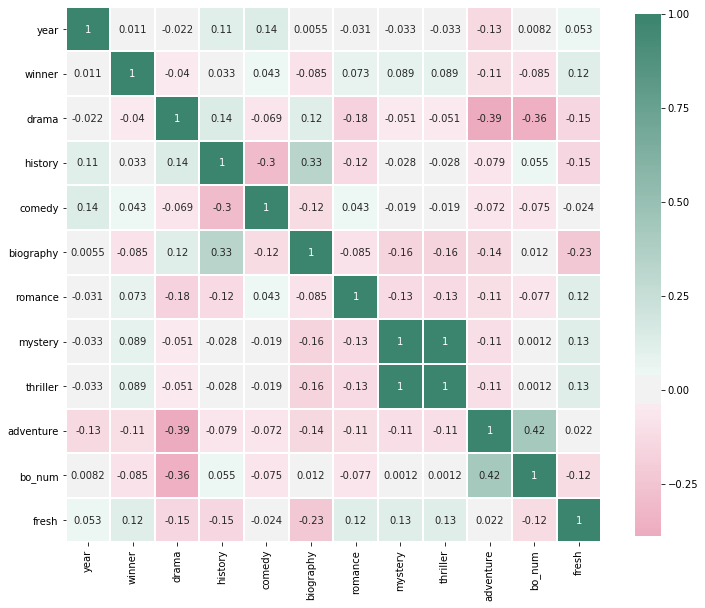

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# call corr on df for correlations of all topics
corr = df_rt_details.corr()
# create figure and set size
f, ax = plt.subplots(figsize=(12, 12))
# create color map
cmap = sns.diverging_palette(0, 160, as_cmap=True)
# generate heatmap based on correlations
sns.heatmap(corr, cmap = cmap, vmax = 1, center = 0, square = True, linewidths = 1, cbar_kws={"shrink": .8}, annot=True)
# set y axis appropriately
ax.set_ylim(12,0)

Correlation Summary:

Focusing on the winner flag, there are only weak correlations (between -0.3 and 0.3) with the selected genres, domestic box office, and rotten tomatoes' freshness score. The highest positive correlation (0.12) is seen with freshness score.

Domestic box office has a very strong positive correlation with adventure movies (0.42).

Films under the drama selection have strong negative correlation with films in the adventure genre (-0.39) and domestic box office (-0.36).

There is also a strong negative correlation (-0.3) of best picture nominated films that fall under the genres of comedy and history. (If you're interested in an excellent historical black comedy, I recommend The Death of Stalin.)

There is a strong positive correlation (0.33) between histories and biographies.

The strongest positive correlation at 1 is between mysteries and thrillers. This would likely decrease if the overall volume of mysteries and thrillers that have been nominated for best picture was greater.

In [179]:
genre_summary = df_rt_details.groupby(['winner'])[['drama','history','comedy','biography',
                                                   'romance','mystery','thriller', 'adventure']].sum().reset_index()

Genre Summary

In [180]:
genre_summary

,winner,drama,history,comedy,biography,romance,mystery,thriller,adventure
0,0,78,19,18,16,9,8,8,8
1,1,10,3,3,1,2,2,2,0


91% (10/11) of all films that won best picture from 2011 - 2021 were dramas. The only winning film not labeled as a drama was The Shape of Water; however, anyone who watched that movies knows that it should be labeled as a drama. Effectively, all Best Picture winners have been dramas during this time period.

In [181]:
df_rt_details.groupby('winner').mean()

,year,drama,history,comedy,biography,romance,mystery,thriller,adventure,bo_num,fresh
winner,,,,,,,,,,,
0,2015.891566,0.939759,0.228916,0.216867,0.192771,0.108434,0.096386,0.096386,0.096386,1.006355e+08,0.881948
1,2016.000000,0.909091,0.272727,0.272727,0.090909,0.181818,0.181818,0.181818,0.000000,7.205556e+07,0.929548


In [182]:
df_rt_details.loc[(df_rt_details['drama'] == 0) & (df_rt_details['winner'] == 1)]['title']

29    the_shape_of_water_2017
Name: title, dtype: object

Although dramas are shown to make less money, they are the only genre that has won best picture since 2011, and possibly earlier. Studios that want to develop best picture winners must be willing to potentially trade box office results for awards prestige, or mitigate the box office loss by producing a drama adventure film.

In [183]:
print('Drama ', df_rt_details[df_rt_details['drama']==1].bo_num.mean()/1000)
print('History ', df_rt_details[df_rt_details['history']==1].bo_num.mean()/1000)
print('Comedy ', df_rt_details[df_rt_details['comedy']==1].bo_num.mean()/1000)
print('Biography ', df_rt_details[df_rt_details['biography']==1].bo_num.mean()/1000)
print('Romance ', df_rt_details[df_rt_details['romance']==1].bo_num.mean()/1000)
print('Mystery ', df_rt_details[df_rt_details['mystery']==1].bo_num.mean()/1000)
print('Thriller ', df_rt_details[df_rt_details['thriller']==1].bo_num.mean()/1000)
print('Adventure ', df_rt_details[df_rt_details['adventure']==1].bo_num.mean()/1000)

Drama  87360.75949367088
History  108226.31578947368
Comedy  83500.0
Biography  100212.5
Romance  75730.0
Mystery  97950.0
Thriller  97950.0
Adventure  244114.2857142857


Rating Summary

Most nominated films are rated R; however, G, PG, and PG-13 are also reflected in the population

In [207]:
df_rt_details.groupby('rating').size()

rating
G         1
PG        4
PG-13    36
R        53
dtype: int64

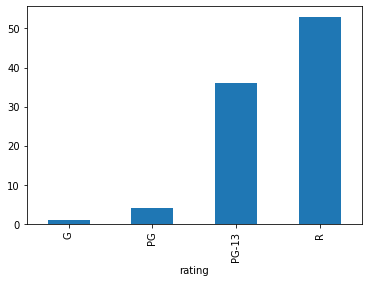

In [184]:
# Volume of nominated films by rating
df_rt_details.groupby('rating').size().plot(kind='bar')

56% of nominated films were rated R, 38% were rated PG-13, 4% were rated PG, and 1% were rated G.

Text(0.5, 1.0, 'Percentage of Nominated Films by Rating')

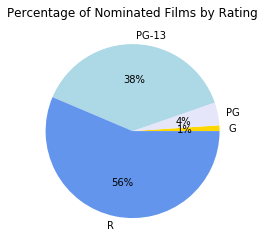

In [185]:
# graph percentage of nominees by rating
plt.pie(df_rt_details.groupby('rating').size(), colors = ['gold', 'lavender','lightblue','cornflowerblue'], labels = ['G', 'PG','PG-13','R'], autopct='%1.f%%')
plt.title('Percentage of Nominated Films by Rating')

No G or PG movies have won best picture.

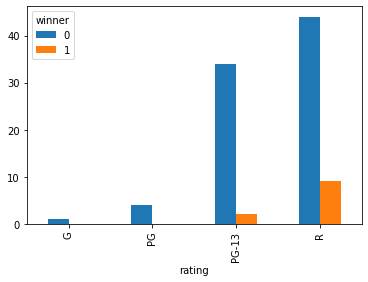

In [186]:
# graph rating against winner
pd.crosstab(df_rt_details.rating,df_rt_details.winner).plot(kind='bar')

82% of best picture winner were nominated R and 18% were nominted PG-13.

Text(0.5, 1.0, 'Percentage of Winners by Rating')

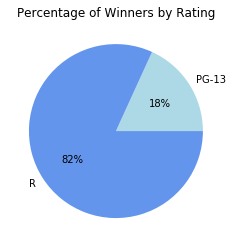

In [187]:
# percentage of winners by rating
plt.pie(df_rt_details[df_rt_details['winner']==1].groupby('rating').size(), colors = ['lightblue','cornflowerblue'], labels = ['PG-13','R'], autopct='%1.f%%')
plt.title('Percentage of Winners by Rating')

Box Office vs Rating

While R rated movies are more likely to win best picture, they do not do as well in the box office. There is not a way to mitigate this loss like there is with genre; however, the studio could develop a G-rated adventure film around the same time they are developing a potential best picture nominee.

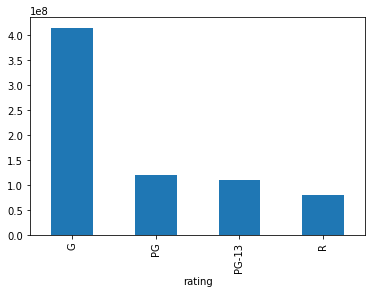

In [189]:
# Graph rating against bo
df_rt_details.groupby('rating').bo_num.mean().plot.bar()

Fresh Score vs Rating

While there is no strong correlation between winning films and the fresh review score, we will see that the freshness score and sentiment scores are higher in winning films. The graph below reflects the lowest average fresh review score for movies rated PG-13, followed by movies rated R and PG. The highest average fresh review score is seen in movies rated G, which we know do not win Best Picture.

A movie studio may think to mitigate box office loss by producing a film rated PG-13 over a film rated R; however, PG-13 movies receive the lowest freshness ratings. As we'll see in the sentiment analysis section, movies with lower freshness ratings are less likely to win Best Picture.

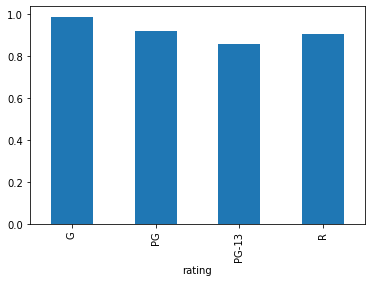

In [191]:
# Graph rating against fresh review score
df_rt_details.groupby('rating').fresh.mean().plot.bar()

Fresh Score Summary

The graph below shows that most winners have high average freshness scores (above 90%) on Rotten Tomatoes; however, Green Book is closer to 70%.

Green Book is likely an outlier as it received backlash after family members of one of the characters depicted in the film raised concerns about the accuracy of the story. Green Book could be skewing the correlation between fresh rating and winning films.

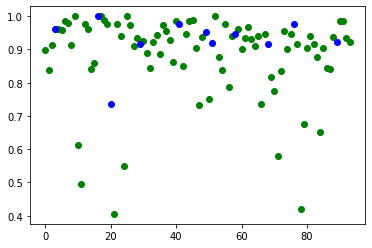

In [202]:
# Scatter plot of winners (blue) vs losers (green) by freshness score
plt.figure()  
dfzero = df_rt_details.loc[df_rt_details['winner'] == 0]
dfone = df_rt_details.loc[df_rt_details['winner'] == 1] 
plt.plot(dfzero['fresh'], 'go') 
plt.plot(dfone['fresh'], 'bo') 

In [203]:
df_rt_details.loc[(df_rt_details['fresh'] < 0.8) & (df_rt_details['winner'] == 1)]['title']

20    green_book
Name: title, dtype: object

Quick Summary of Best Picutre Nominees:

1. Dramas win best picture
2. Dramas have poor box office performance
3. Adventures perform well in the box office
4. Films rated R are more likely to win best picture
5. Rilms rated G and PG have not won best picture since at least 2011
6. Films rated PG-13 receive the lowest fresh ratings
7. Films with fresh ratings over 90% are more likely to win best picture

### Work cloud/Word Frequency

#### Descriptive Analytics of Twitter Data

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# wc function produces and plots a wordcloud based on text
def wc(text):
    wordcloud = WordCloud(background_color="whitesmoke", collocations=False, stopwords=STOPWORDS).generate(" ".join(text))
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [209]:
# import Counter
from collections import Counter

# fd function returns frequency distribution
def fd(text):
    return list(Counter(" ".join(text).split(" ")).items())

# fd_df function returns dataframe of frequency distribution
def fd_df(fd):
    freq_word = []
    for k,v in fd:
        freq_word.append([k,v])
    return pd.DataFrame(freq_word, columns = ['word','frequency'])

In [36]:
# top 10 words seen in gathered original tweets
fd_df(fd(df['cleaned'])).sort_values('frequency', ascending=False).head(10)

,word,frequency
1,oscar,11707
17,father,2824
14,nomadland,1542
12,best,1263
135,watch,928
389,year,917
213,minari,888
194,oscars2021,861
11,mank,837
309,sound,833


The 10 most frequently used words in the gathered tweets are:

1. oscar
2. father
3. nomadland
4. best
5. watch
6. year
7. minaru
8. oscars2021
9. mank
10. sound

Based on this word frequency, it may be expected for Father to win best picture; however, we'll see the data for Father is slightly skewed.

The following word frequency distrubtions will reflect tweets that only mention a single movie to avoid skewing the frequency distribution.

In [37]:
# column names used in twitter dataframe to indicate movies in tweet text
titles = ['minari','promising','mank','sound','judas','trial','nomadland','father']

# for each title
for i in titles:
    # print the title name
    print('\n', i)
    # print the top 10 words in the frequency distribution
    # where title is the only movie found in the tweet text
    print(fd_df(fd(df.loc[(df[i] == 1) & (df['bestpic_flags'] == 1)]['cleaned'])).sort_values('frequency', ascending=False).head(10))


 minari
          word  frequency
0       minari        551
11       oscar        133
53        best         63
54     picture         41
43        year         33
44        give         31
45  prediction         28
41     feeling         27
47     awesome         27
48        gift         26

 promising
          word  frequency
1        young        461
0    promising        460
2        woman        459
53       oscar         89
14       carey         37
15    mulligan         37
77        film         31
212       best         31
24       mejor         30
66       filme         22

 mank
         word  frequency
4        mank        631
71      oscar        110
68      filme         40
43       best         39
66    fincher         37
63      tirei         35
452  película         25
159    melhor         25
179     david         25
94      mejor         24

 sound
             word  frequency
1           sound        495
2           metal        471
7           oscar        162
6

The frequency distribution for father contains some religious words. We'll remove any religious tweets from this frequency distriubtion.

The Father

1.        father        850
2.      hopkins        103
3.       anthony        102
4.        oscar        100
5.       filme         47
6.         best         45
7.        sin         36
8.       done         35
9.  mentioned         33
10.   forgives         33

In [38]:
# flag any tweets with the words "god" and "holy" in the dataframe
df['religious'] = df.text.str.contains("god|holy")
# function to convert bool to int
f = lambda x: x * 1
df['religious'] = df['religious'].apply(f)

In [39]:
# father2 column will be 1 if father == 1 and religious is == 0
df['father2'] = df['father'] * (1 - df['religious'])

In [40]:
# View change in father frequency distribution
fd_df(fd(df.loc[(df['father2'] == 1) & (df['bestpic_flags'] == 1)]['cleaned'])).sort_values('frequency', ascending=False).head(10)

,word,frequency
2,father,771
9,hopkins,103
8,anthony,102
97,oscar,100
240,filme,47
49,best,44
20,film,31
537,melhor,27
492,like,27
16,para,25


The frequency of the word "father" decreased from 850 to 771 with the exclusion of religious tweets. The words "sin" and "forgives" also no longer appear in the frequency distribution.

In [41]:
titles2 = ['minari','promising','mank','sound','judas','trial','nomadland','father2']

I was curious if any interesting results would be found by excluding words that are common to all film tweets.

In [42]:
# this dataframes will hold the cleaned text of tweets that only mention a specific film
minari = fd_df(fd(df.loc[(df['minari'] == 1) & (df['bestpic_flags'] == 1)]['cleaned']))
promising = fd_df(fd(df.loc[(df['promising'] == 1) & (df['bestpic_flags'] == 1)]['cleaned']))
mank = fd_df(fd(df.loc[(df['mank'] == 1) & (df['bestpic_flags'] == 1)]['cleaned'])) 
sound = fd_df(fd(df.loc[(df['sound'] == 1) & (df['bestpic_flags'] == 1)]['cleaned']))
judas = fd_df(fd(df.loc[(df['judas'] == 1) & (df['bestpic_flags'] == 1)]['cleaned']))
trial = fd_df(fd(df.loc[(df['trial'] == 1) & (df['bestpic_flags'] == 1)]['cleaned']))
nomadland = fd_df(fd(df.loc[(df['nomadland'] == 1) & (df['bestpic_flags'] == 1)]['cleaned']))
father2 = fd_df(fd(df.loc[(df['father2'] == 1) & (df['bestpic_flags'] == 1)]['cleaned']))

In [43]:
# remWords function removes words occuring in df2 from df1
def remWords(df1, df2):
    return df1[~df1.word.isin(df2)].reset_index(drop=True)

Words specific to Minari include the movie title, the director's name (Isaac Chung), the state the movie is set in (Arkansas), and one of the main character's last names (Yuen).

In [44]:
# minari specific words
minari_comp = promising['word'].append(mank['word']).append(sound['word']).append(judas['word']).append(trial['word']).append(nomadland['word']).append(father2['word'])
minari_unique = remWords(minari, minari_comp)
minari_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
0,minari,551
19,minaris,26
24,isaac,19
25,chung,18
33,minarimovie,15
99,alan,8
116,arkansas,5
781,theivylakes,5
390,americano,4
239,yuen,4


Words specific to Promising Young Woman indicate that the movie involves sexual assault. Hombre and odio are spanish words, and paris and charli do not appear to have anything to do with the film.

In [45]:
# promising young woman specific words
promising_comp = minari['word'].append(mank['word']).append(sound['word']).append(judas['word']).append(trial['word']).append(nomadland['word']).append(father2['word'])
promising_unique = remWords(promising, promising_comp)
promising_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
36,promisingyoungwoman,18
263,thriller,6
925,gutpunch,5
924,elegant,5
149,rape,5
1,paris,3
197,toxic,3
200,charli,3
611,bros,3
264,cantando,3


Words specific to Mank include citizen and kane, which is the movie the film is based on. The main character, Mankiewicz, also appears in the list. The other words appear to be non-Enligsh.

In [46]:
# mank specific words
mank_comp = minari['word'].append(promising['word']).append(sound['word']).append(judas['word']).append(trial['word']).append(nomadland['word']).append(father2['word'])
mank_unique = remWords(mank, mank_comp)
mank_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
2,mank,631
588,kane,5
347,mankiewicz,4
484,mankfilm,4
587,citizen,4
198,vestuario,4
346,herman,4
397,tentei,4
33,httpstcohsy8hynbfo,4
287,gustan,4


Words specific to The Sound of Metal include the director (Darius Marder), deaf, and baterista (the Spanish word for drummer). The movie focuses on a drummer who loses his hearing. Michelob and ultra also appear in the list, so it's possible they were sponsoring some twitter-based advertisement related to the movie.

In [47]:
# sound of metal specific words
sound_comp = minari['word'].append(promising['word']).append(mank['word']).append(judas['word']).append(trial['word']).append(nomadland['word']).append(father2['word'])
sound_unique = remWords(sound, sound_comp)
sound_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
21,soundofmetal,61
79,marder,15
78,darius,14
125,deaf,9
87,2019,6
744,stereotype,6
15,michelob,5
364,baterista,5
11,bell,5
16,ultra,5


Words specific to Judas and Black Messiah include the director's name, Shaka King. Fred is the first name of one of the main characters of the film, and O'Neal is the last name of a different main character.

In [48]:
# judas and the black messiah specific words
judas_comp = minari['word'].append(promising['word']).append(mank['word']).append(sound['word']).append(trial['word']).append(nomadland['word']).append(father2['word'])
judas_unique = remWords(judas, judas_comp)
judas_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
34,judasandtheblackmessiah,8
6,king,8
5,shaka,7
1,fred,5
28,intéressants,2
14,negras,2
335,tonnie_montana,2
208,oneal,2
30,jattend,2
29,parce,2


Words specific to The Trial of the Chicago 7 include the first and last name of Sacha Baron Cohen, who was nominated for best supporting actor for his role in this film. Sorkin is the last name of the director.

In [49]:
# trial of the chicago 7 specific words
trial_comp = minari['word'].append(promising['word']).append(mank['word']).append(sound['word']).append(judas['word']).append(nomadland['word']).append(father2['word'])
trial_unique = remWords(trial, trial_comp)
trial_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
0,sacha,5
1,cohen,5
7,thetrialofthechicago7,4
12,trialofthechicago7,3
44,sorkins,2
37,boldest,2
19,face,2
34,httpstcorehkuzhhna,1
35,httpstcovaeududfs4,1
36,flick,1


There are not many interesting words specific to Nomadland in the data other than the word eternal. The director of Nomadland will be directing The Eternals, an upcoming Marvel movie.

In [50]:
# nomandland specific words
nomadland_comp = minari['word'].append(promising['word']).append(mank['word']).append(sound['word']).append(judas['word']).append(trial['word']).append(father2['word'])
nomadland_unique = remWords(nomadland, nomadland_comp)
nomadland_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
0,nomadland,1073
28,nomadlands,77
2093,cinepolis,12
24,nomadlandfilm,9
389,directora,7
560,nomadlande,5
507,nomadlandi,5
252,eternals,5
38,vence,5
198,ganadora,5


The director of The Father (Florian Zeller) shows up on the list of words specific to the film. Child and dementia also show up in the list, which tracks as the film is about a woman who must home her father due to his severe dementia. However, no one in the movie is named John and no one in the movie is pregnant.

In [51]:
# father specific words
father2_comp = minari['word'].append(promising['word']).append(mank['word']).append(sound['word']).append(judas['word']).append(trial['word']).append(nomadland['word'])
father2_unique = remWords(father2, father2_comp)
father2_unique.sort_values('frequency', ascending=False).head(10)

,word,frequency
26,florian,19
27,zeller,18
409,child,18
28,thefather,15
126,dementia,13
178,john,8
284,pregnant,7
285,saved,7
1209,died,7
1473,reminder,6


Film Tweet Word Clouds

Overall, the film specific frequency distributions seem to be missing important words. The following word clouds do not exclude words that can be found in tweets related to other films, but do try to capture tweets that are only about the associated film.

The primary words seen are the movie titles, the director, some actors, and positive adjectives. The words associated with Nomadland tweets, the winner, are not much different than of the other nominees. It appears that most people are tweeting in support of these movies without much criticsm.

Quite a few Spanish words are also seen. A good next step would be to see if it's possible to import a dictionary of Spanish stop words.


 minari


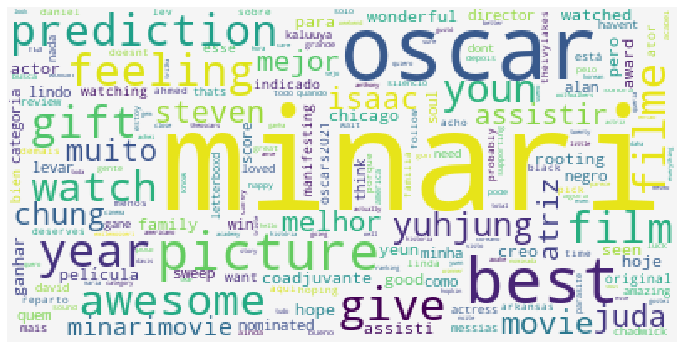


 promising


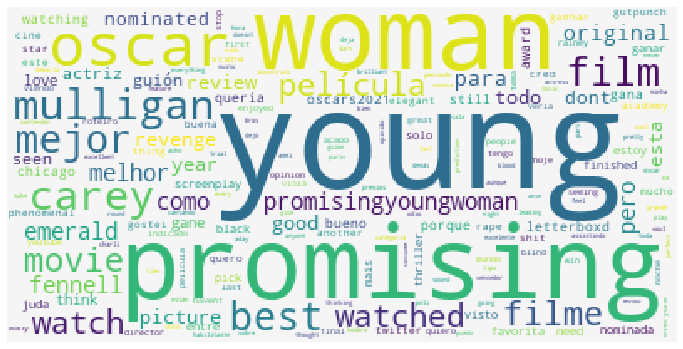


 mank


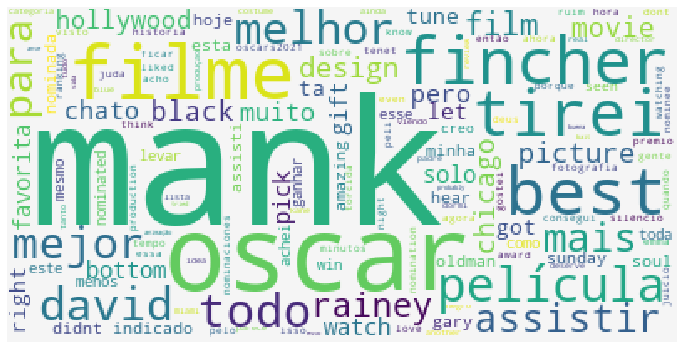


 sound


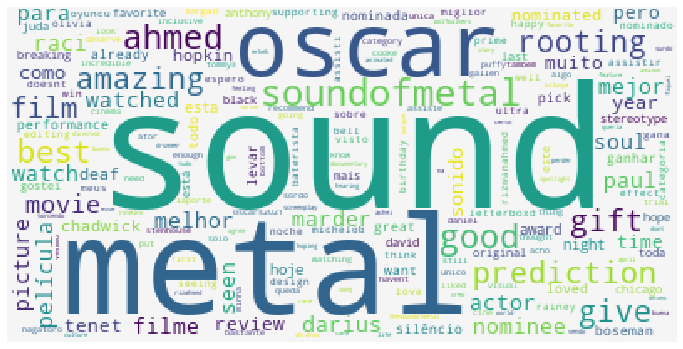


 judas


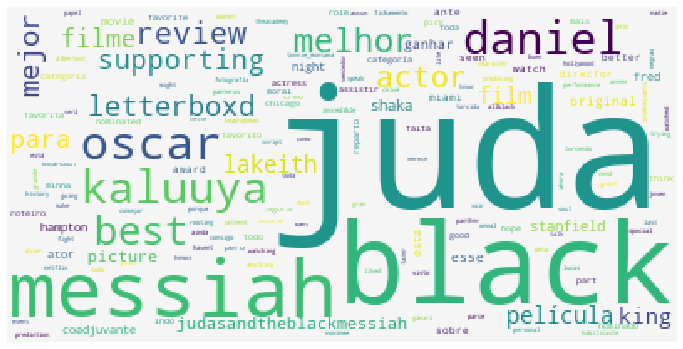


 trial


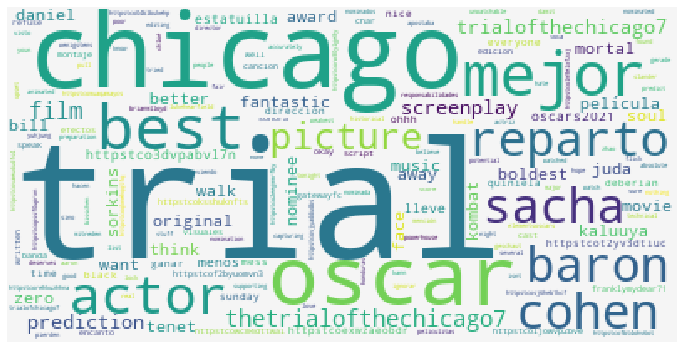


 nomadland


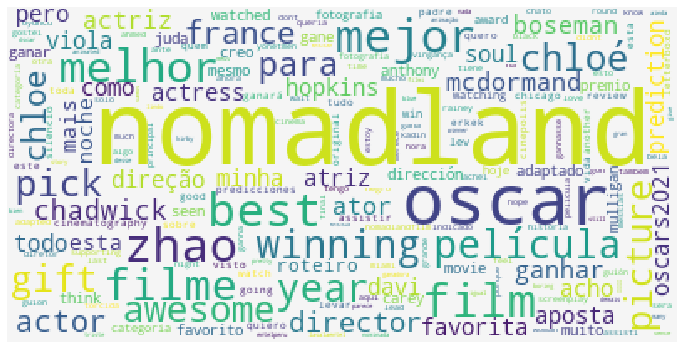


 father2


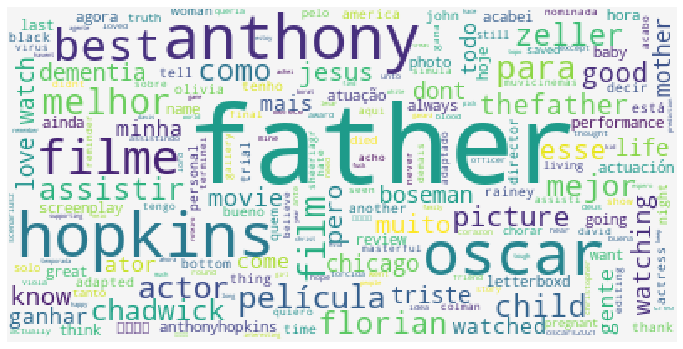

In [52]:
for i in titles2:
    print('\n', i)
    wc(df.loc[(df[i] == 1) & (df['bestpic_flags'] == 1)]['cleaned'])

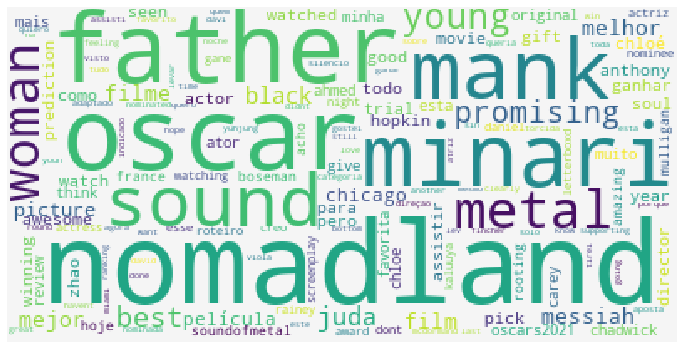

In [73]:
# Most common words in all tweets that mention a film.
# generate wordcloud based on all films
wc(df[df['bestpic_flags'] > 0]['cleaned'])

The prior cloud below displays the most common words in tweets about all nominated films, not just tweets that mention the Oscars.

These tweets were gathered before the Oscars were aired. Nomadland, which won, is the most frequently seen word.

Analyzing twitter data may provide an indication to movie studios if their nominted film may win Best Picture.

In [210]:
# top 10 words seen in gathered original tweets where any film was mentioned
fd_df(fd(df[df['bestpic_flags'] > 0]['cleaned'])).sort_values('frequency', ascending=False).head(10)

,word,frequency
4,nomadland,1542
33,oscar,1242
7,father,1148
38,minari,888
1,mank,837
71,sound,787
72,metal,731
75,woman,667
74,young,662
141,promising,657


## 4. Content analytics

### 4.1 Topic Modeling

Topic modeling will be performed on the Rotten Tomatoes movie synopses to see if there are any prevelant topics among nominees.

In [10]:
# Create dictionary based on cleaned text
dictionary = Dictionary(cleaned_syn)
# Remove words that appear in less than 2 documents or more than 20% documents 
dictionary.filter_extremes(no_below=2, no_above=0.2)
# store dictionary for future reference
dictionary.save('final.dict')
# convert words to vetors or integers
corpus = [dictionary.doc2bow(txt) for txt in cleaned_syn]
# store corpus for future reference
corpora.MmCorpus.serialize('final.mm', corpus)
# check the length
print(len(dictionary))
len(corpus)

505


94

In [11]:
# to access saved dictionary 
# dictionary = Dictionary.load('final.dict')

# to access saved corpus
# corpus = corpora.MmCorpus('final.mm')

In [13]:
# build lda model with 38 topics
np.random.seed(1) # setting random seed 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=38, passes=50)

Topics 2 and 34 are the most prevelent.

2 :  get, woman, 1950s, star, movie, come, muse, strongwilled, british, sister  
34 :  despite, right, making, fall, woodys, left, hope, odds, fellow, love

In [262]:
# print the top 10 words in all 38 topics
print('All Topics:')
for i in range(0,38):
    topics = model.show_topic(i, 10)
    print((i+1),': ',', '.join([str(word[0]) for word in topics]))

All Topics:
1 :  year, forever, drummer, jazz, american, potential, film, another, black, unexpected
2 :  get, woman, 1950s, star, movie, come, muse, strongwilled, british, sister
3 :  king, space, home, hope, panther, black, capture, career, promise, artist
4 :  nation, lincoln, home, call, left, embarks, important, alone, place, maintain
5 :  world, newly, prime, odds, negotiate, legacy, western, hitler, four, week
6 :  panther, danger, family, comrade, good, becomes, friend, home, target, fortune
7 :  albert, father, queen, live, lead, fate, beloved, history, british, home
8 :  ally, battle, fight, fall, career, demon, love, discovers, struggling, take
9 :  house, named, teenage, chief, country, presidential, arise, complication, texas, invite
10 :  love, hard, dream, decision, affair, threaten, faced, maintain, drawn, success
11 :  help, decides, worker, care, child, complication, arise, kid, mind, four
12 :  british, french, 1940, force, mission, could, soldier, cover, every, foun

In [14]:
# store model for future use
model.save('lda_final.model')

# use code below to retrieve
# model = models.LdaModel.load('lda_final.model')

In [15]:
# save document-topic distribution 
lda_corpus = model[corpus]
results = []
for i in lda_corpus:
    results.append(i)

In [16]:
# list of topic with highest probability
toptopic = [max(collection, key=lambda x: x[1])[0] for collection in results]

In [17]:
# combine toptopic with original df

# convert toptopic to dataframe
toptopic = pd.DataFrame(toptopic)

# convert original data to dataframe
dfdata = pd.DataFrame(cleaned_syn)

# rename column
dfdata = dfdata.rename(columns={0: 'documents'})

# join into summary
summary = dfdata.join(toptopic)

In [18]:
# View value counts of column 0

summary[0].value_counts()

34    6
2     6
30    5
5     5
0     4
1     4
29    4
11    4
22    3
35    3
33    3
17    3
6     3
15    2
12    2
3     2
10    2
8     2
16    2
18    2
36    2
24    2
32    2
31    2
28    2
27    2
19    2
25    2
23    2
9     1
7     1
26    1
21    1
4     1
13    1
14    1
20    1
37    1
Name: 0, dtype: int64

In [19]:
# listify function provided in labs

def listify(l):
    res = []
    for j in l:
        d = dict([(i, 0) for i in range(38)])  # create a dictionary
        d.update(j)
        res.append(list(d.values()))  # saving values
    return res

In [20]:
# call listify on document-term distribution
z = listify(results)

# save as data frame
dtd = pd.DataFrame(z)

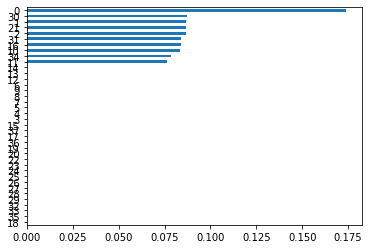

In [287]:
# join original data with document-term distribution
dfum = df_rt_details.join(dtd)
# create df of only winnining films
dfum_w = dfum[dfum['winner']==1]
# remove columns to form winning film document-term distribution
dtd_w = dfum_w.drop(['year','title','synopsis','long_rating','genre','director','writer','release_date','bo','rating','winner',
                     'cleaned_syn','drama','history','comedy','biography','romance','mystery','thriller','adventure','bo_num','fresh'], axis=1)
# prevalence graph of winners
(dtd_w.sum(axis=0).sort_values() / len(dtd_w)).plot(kind='barh')

The prevelence graph above shows that topic 0 is the most prevelent among Best Picture winners.

Topic Word Clouds

The word clouds of topics associated with the synopses of best picture winners are below. All of which sound like they would make excellent films.

However, topic 0, had two associated winning best pictures. Depending on the accuracy of this topic modeling, a movie studio may wish to produce a film about a black American Jazz Drummer, who moves to New York after discovering a passion for teaching.

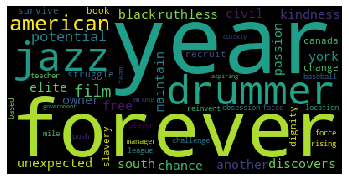

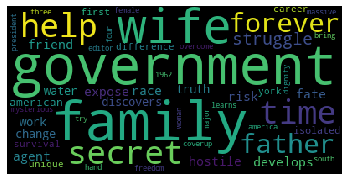

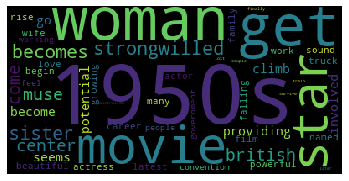

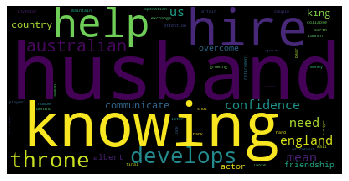

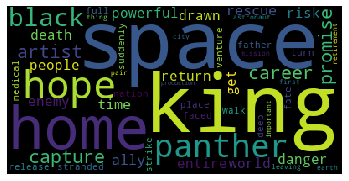

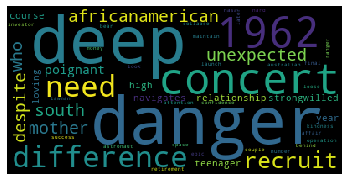

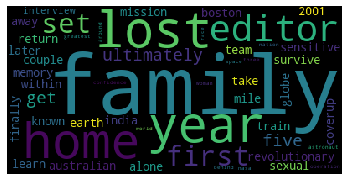

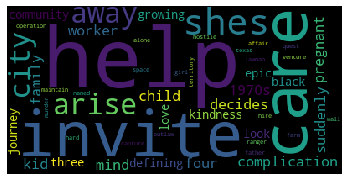

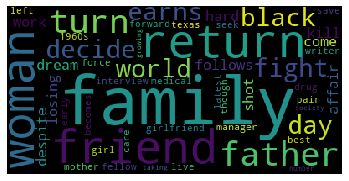

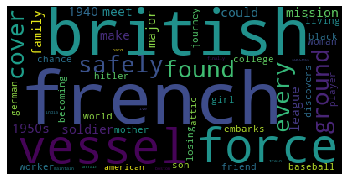

In [290]:
# word clouds for topics associated with best picture winners
for i in [0,30,1,21,2,31,16,10,34,11]:
    plt.figure(figsize=(6,6))
    plt.imshow(WordCloud().fit_words(dict(model.show_topic(i,50))))
    plt.axis("off")

### 4.1 Sentiment Analysis

In this section, the Bing Liu, TextBlob, and Vader sentiment analysis methodologies will be used on the cleaned rotten tomato reviews.

In [44]:
# Bing Liu Method

# save the given positive and negative words
positive_words = open("Module4/data/positive-words.txt", "r", encoding = "ISO-8859-1").read().splitlines()
negative_words = open("Module4/data/negative-words.txt", "r", encoding = "ISO-8859-1").read().splitlines()

In [399]:
# empty list
finaldata = []

for sentence in cleaned_rev:  # for each review
    positive = 0
    negative = 0
    for word in sentence:
        if word in positive_words:
            positive += 1    # count total number of positive words in review
        elif word in negative_words:
            negative += 1    # count total number of negative words in review
    finaldata.append([sentence,positive,negative])   # place tokenized words, negative word total, 
                                                     # and positive word total in finaldata

In [400]:
len(finaldata)

7278

In [401]:
# place cleaned review, positive score, and negative score in df
dfBL = pd.DataFrame(finaldata)
dfBL.columns = ['review','positive','negative']

# create compoundscore column that stores difference between positive and negative word counts
dfBL['compoundscore'] = dfBL['positive'] - dfBL['negative']

In [402]:
# positive_review, negative_review, and neutral_review contain the sentiment review totals using the Bing Liu method
positive_review = dfBL.loc[dfBL['compoundscore'] > 0] # if compoundscore is > 0 then positive
negative_review = dfBL.loc[dfBL['compoundscore'] < 0] # if compoundscore is < 0 then negative
neutral_review = dfBL.loc[dfBL['compoundscore'] == 0] # if compoundscore is == 0 then neutral

In [404]:
# TextBlob Method

# empty list
finaldata2 = []

for row in df_rt_reviews['cleaned']:    # for each review
    finaldata2.append([row, TextBlob(row).sentiment.polarity, TextBlob(row).sentiment.subjectivity]) 
                         # add result of TextBlob sentiment analysis of cleaned reviews into finaldata2
        
# place review, sentiment score, and subjectivity score in df2
dfTB = pd.DataFrame(finaldata2)
dfTB.columns = ['review','sentiment','subjectivity']

# positive_review2, negative_review2, and neutral_review2 contain the sentiment
# review totals using the Textblob package
positive_review2 = dfTB.loc[dfTB['sentiment'] > 0] # if compoundscore is > 0 then positive
negative_review2 = dfTB.loc[dfTB['sentiment'] < 0] # if compoundscore is < 0 then negative
neutral_review2 = dfTB.loc[dfTB['sentiment'] == 0] # if compoundscore is < 0 then negative

In [405]:
# confirm there are 7,278 scores
len(finaldata2)

7278

In [406]:
# Vader Methodology
analyzer = SentimentIntensityAnalyzer()

# empty list
finaldata3 = []

for sentence in df_rt_reviews['cleaned']:   # for each review
    vs = analyzer.polarity_scores(sentence)
    finaldata3.append([sentence,vs['compound']]) # add review and result to finaldata3
    
# place review and score in df3
dfV = pd.DataFrame(finaldata3)
dfV.columns = ['review','compound']

# positive_review3, negative_review3, and neutral_review3 contain the sentiment review totals
# using the vaderSentiment package
positive_review3 = dfV.loc[dfV['compound'] > 0] # if compoundscore is > 0 then positive
negative_review3 = dfV.loc[dfV['compound'] < 0] # if compoundscore is < 0 then negative
neutral_review3 = dfV.loc[dfV['compound'] == 0] # if compoundscore is < 0 then negative

In [407]:
# confirm there are 7,278 scores
len(dfV)

7278

Bing Liu scores 3,936 reviews as positive, 1,641 as negative, and 1,701 as neutral.
TextBlob scores 4,767 reviews as positive, 1,327 as negative, and 1,184 as neutral.
Vader scores 4,933 reviews as positive, 1,525 as negative, and 821 as neutral

In [408]:
# create summary dataframe that contains the total number of positive, negative, and neutral reviews
# of Bing Liu, Textblob, and Vader sentiment analyses

summary = pd.DataFrame({'Analysis' : ['Bing Liu','Textblob','Vader'], 'Positive Reviews' : [len(positive_review), len(positive_review2), len(positive_review3)], 'Negative Reviews' : [len(negative_review), len(negative_review2), len(negative_review3)], 'Neutral Reviews' : [len(neutral_review), len(neutral_review2), len(neutral_review3)]})
summary['Total'] = summary['Positive Reviews'] + summary['Negative Reviews'] + summary['Neutral Reviews']
summary

,Analysis,Positive Reviews,Negative Reviews,Neutral Reviews,Total
0,Bing Liu,3936,1641,1701,7278
1,Textblob,4767,1327,1184,7278
2,Vader,4933,1524,821,7278


In [409]:
# join reviews with all three sentiment scores

fullsummary = dfBL.merge(dfTB[['sentiment']], how='outer', left_index=True, right_index=True).merge(dfV[['compound']], how='outer', left_index=True, right_index=True)
fullsummary = fullsummary.drop(['positive', 'negative'], axis=1)
fullsummary = fullsummary.rename(columns={"compoundscore": "Bing Liu", "sentiment": "Textblob", "compound": "Vader"})

fullsummary.head(2)

,review,Bing Liu,Textblob,Vader
0,"[example, screenwriting, film, pretty, great]",2,0.525,0.8074
1,"[mank, love, letter, poison, though, like, much, meticulous, director, output, film, thats, film, though, often, made, look, like, weighed, burden, time]",2,0.350,0.4215


In [437]:
# join with fresh score, winner flag, and nomination year
full_sum = pd.merge(fullsummary,df_rt_reviews[['fresh','winner','year']],left_index=True,right_index=True,how='left').reset_index(drop=True)

Winning Oscar nominated films have higher sentiment scores for BingLiu, TextBlob, and Vader, in addition to a higher freshness score when compared to the losing Oscar nominated films.

The sentiment scores have a weak positive correlation with best picture winners. The freshnes score has a slightly stronger positive correlation at 0.05, but that is still weak overall. The strongest correlations are seen between the three sentiment analysis scores.

In [438]:
# Average of sentiment scores and freshness rating of winners and losers
full_sum.groupby('winner').mean()

,Bing Liu,Textblob,Vader,fresh,year
winner,,,,,
0.0,0.640057,0.172912,0.300192,0.884900,2016.005668
1.0,0.749460,0.193366,0.331157,0.933045,2015.982721


          Bing Liu  Textblob     Vader     fresh    winner      year
Bing Liu  1.000000  0.413400  0.593266  0.165988  0.021028 -0.006372
Textblob  0.413400  1.000000  0.438300  0.135236  0.022675 -0.011875
Vader     0.593266  0.438300  1.000000  0.137944  0.022204 -0.027408
fresh     0.165988  0.135236  0.137944  1.000000  0.051490  0.011271
winner    0.021028  0.022675  0.022204  0.051490  1.000000 -0.002468
year     -0.006372 -0.011875 -0.027408  0.011271 -0.002468  1.000000


<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


(6, 0)

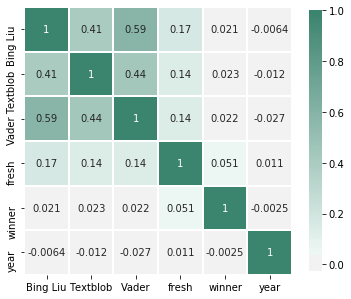

In [439]:
# call corr on df for correlations of all topics
corr = full_sum.corr()

print(corr)

# create figure and set size
f, ax = plt.subplots(figsize=(6, 6))

# create color map
cmap = sns.diverging_palette(0, 160, as_cmap=True)

# generate heatmap based on correlations
sns.heatmap(corr, cmap = cmap, vmax = 1, center = 0, annot=True, square = True, linewidths = 1, cbar_kws={"shrink": .8}, )

# set y axis appropriately
ax.set_ylim(6,0)

The increase seen in sentiment scores and freshness rating of winning films compared to losing films could be an effect of winning an Oscar if the reviews were written after the film won or lost. The perceived quality of the film is likely linked to winning or losing the award, and a review may then be biased.

The date associated with the Rotten Tomato review date is the date the reviews was loaded, and not the date it was written. Therefore, we cannot exclude reviews written after a film either won or lost an Oscar.

However, this data was gathered prior to the 2021 Oscars. The reviews of films nominated this year wouldn't be biased in this manner. When looking only at reviews of films in 2021, the BingLiu score, Vader score, and fresh Score are all higher for Nomadland (the winner) compared to the other nominees; however, the Textblob score is much lower, and actually has a weak negative correlation with winning.

In [443]:
full_sum[full_sum['year']==2021].groupby('winner').mean()

,Bing Liu,Textblob,Vader,fresh,year
winner,,,,,
0.0,0.612832,0.167870,0.266336,0.931416,2021.0
1.0,0.912500,0.137126,0.393409,0.962500,2021.0


          Bing Liu  Textblob     Vader     fresh    winner  year
Bing Liu  1.000000  0.402278  0.609398  0.100718  0.062758   NaN
Textblob  0.402278  1.000000  0.450733  0.048783 -0.039394   NaN
Vader     0.609398  0.450733  1.000000  0.071258  0.100139   NaN
fresh     0.100718  0.048783  0.071258  1.000000  0.045425   NaN
winner    0.062758 -0.039394  0.100139  0.045425  1.000000   NaN
year           NaN       NaN       NaN       NaN       NaN   NaN


<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


(6, 0)

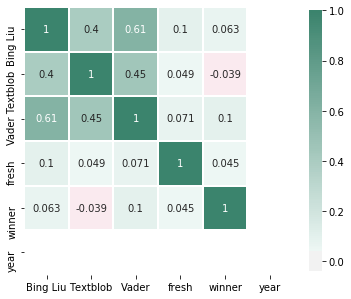

In [445]:
# call corr on df for correlations of all topics
corr = full_sum[full_sum['year']==2021].corr()

print(corr)

# create figure and set size
f, ax = plt.subplots(figsize=(6, 6))

# create color map
cmap = sns.diverging_palette(0, 160, as_cmap=True)

# generate heatmap based on correlations
sns.heatmap(corr, cmap = cmap, vmax = 1, center = 0, annot=True, square = True, linewidths = 1, cbar_kws={"shrink": .8}, )

# set y axis appropriately
ax.set_ylim(6,0)

## 5. Network Analysis

The actor_network dataframe will be used, which has already been saved to actor_network.csv

Full Network

The average degree of each node is 2.07. On average, a person or movie is associated with 2 other nodes. The network diameter, which is longest path between a set of nodes, is 36 edges. The density of the network is at 0.0001, which means that 0.01% of all possible connections exist within the network.

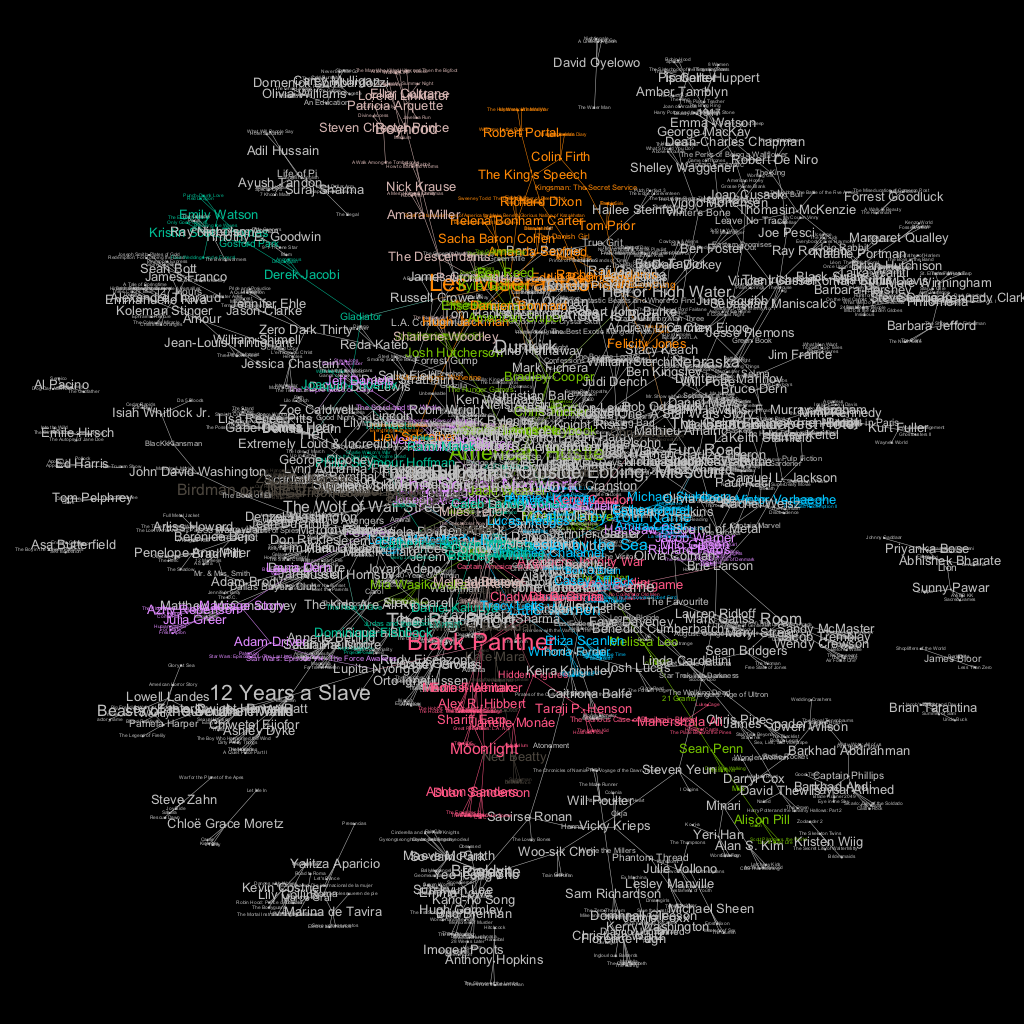

In [6]:
from IPython.display import Image
Image("Network00.png")

In [291]:
# load Gephi network scores
network_results = pd.read_csv('NetworkResults.csv', index_col=0)
# drop useless columns
network_results = network_results.drop(['timeset', 'clustering','triangles'], axis=1)
network_results.head(2)

,Label,Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,eigencentrality,modularity_class
Id,,,,,,,,
A Single Man,A Single Man,1,26,0.076114,0.085352,0.000000,0.058247,1
Colin Firth,Colin Firth,4,25,0.082379,0.095843,2870.108138,0.170280,1


The top 6 films with the most actors that have been in an oscar nominated best pictures are:

1. Black Panther
2. Les Miserables
3. American Hustle
4. The Big Short
5. 12 Years a Slave (won best picture in 2014)
6. The Social Network

In [292]:
network_results.sort_values('Degree', ascending=False).head(6)

,Label,Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,eigencentrality,modularity_class
Id,,,,,,,,
Black Panther,Black Panther,8,22,0.104544,0.135089,81257.786485,1.000000,48
Les Misérables,Les Misérables,8,22,0.107037,0.134129,63858.464489,0.862099,1
American Hustle,American Hustle,7,20,0.108555,0.133414,52353.292647,0.732279,6
The Big Short,The Big Short,7,24,0.108892,0.135412,38566.568401,0.680149,31
12 Years a Slave,12 Years a Slave,7,24,0.091152,0.116126,39401.555430,0.685388,47
The Social Network,The Social Network,7,26,0.097018,0.123463,52209.175234,0.649338,7


The films The Imitation Game and Inception, as well as the actors Ben Mendelsohn, Jacki Weaver, and Viola Davis, have the highest betweeness centrality measure. These movies and these actors appear frequently on the shortest path between two nodes.

In [294]:
network_results.sort_values('betweenesscentrality', ascending=False).head(5)

,Label,Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,eigencentrality,modularity_class
Id,,,,,,,,
The Imitation Game,The Imitation Game,5,24,0.106011,0.127569,104945.017907,0.383037,41
Ben Mendelsohn,Ben Mendelsohn,4,23,0.109361,0.128236,104298.391438,0.299874,65
Jacki Weaver,Jacki Weaver,4,21,0.118358,0.137256,101970.425754,0.297017,6
Viola Davis,Viola Davis,4,19,0.119783,0.141217,86830.226844,0.365402,32
Inception,Inception,6,22,0.114182,0.140465,84781.037850,0.639257,23


The films Black Panther, Les Miserables, and American Hustle all have high eigen centrality measures, which indicates they are all connected to actors with high degree measures.

In [298]:
network_results.sort_values('eigencentrality', ascending=False).head(3)

,Label,Degree,Eccentricity,closnesscentrality,harmonicclosnesscentrality,betweenesscentrality,eigencentrality,modularity_class
Id,,,,,,,,
Black Panther,Black Panther,8,22,0.104544,0.135089,81257.786485,1.000000,48
Les Misérables,Les Misérables,8,22,0.107037,0.134129,63858.464489,0.862099,1
American Hustle,American Hustle,7,20,0.108555,0.133414,52353.292647,0.732279,6


Modularity class 7 is the largest with 52 nodes, and classes 39, 6, and 46 are the second largest with 48 nodes.

In [40]:
modclasssize = pd.DataFrame(network_results.groupby('modularity_class').size())
modclasssize.sort_values(0, ascending=False).head(4)

,0
modularity_class,
7,52
39,48
6,48
46,48


Modularity Class 7

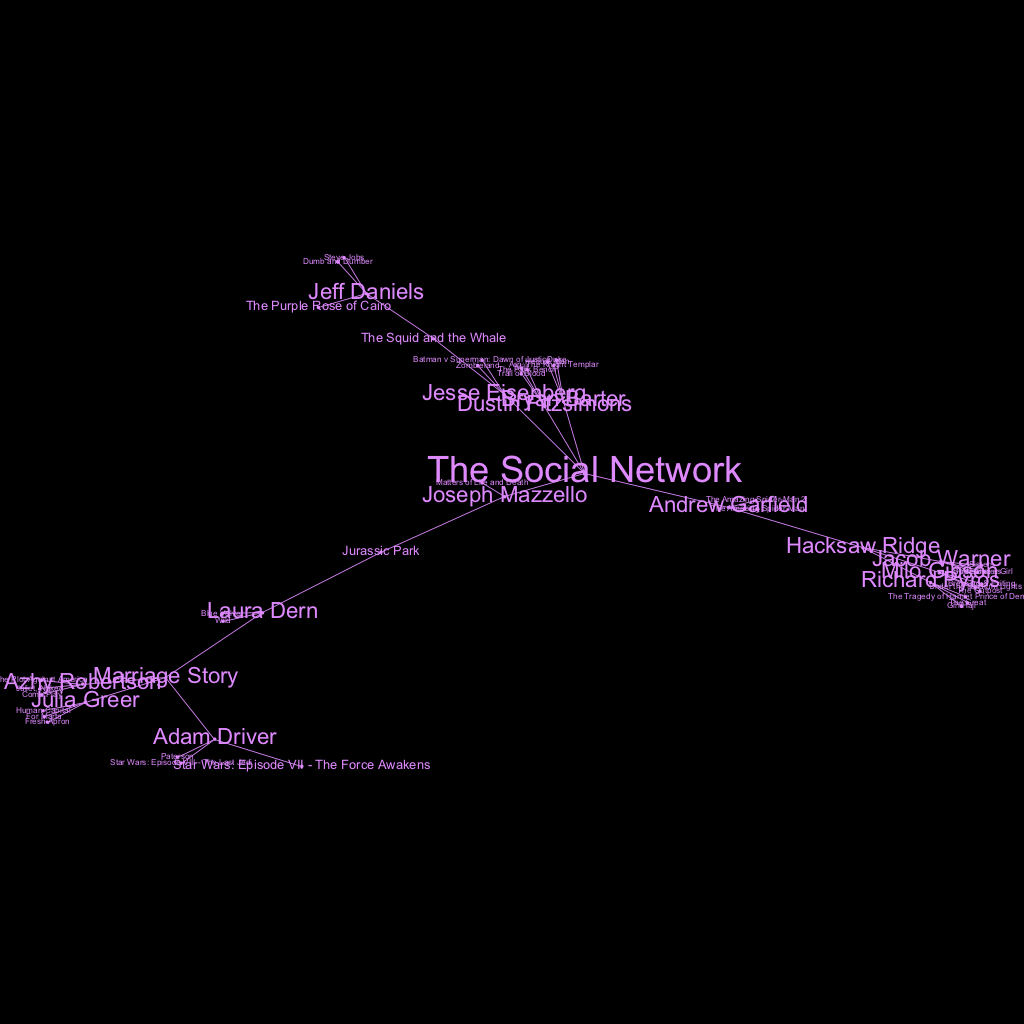

In [41]:
from IPython.display import Image
Image("Network01.png")

Modularity Classes 7, 39, 6, and 36

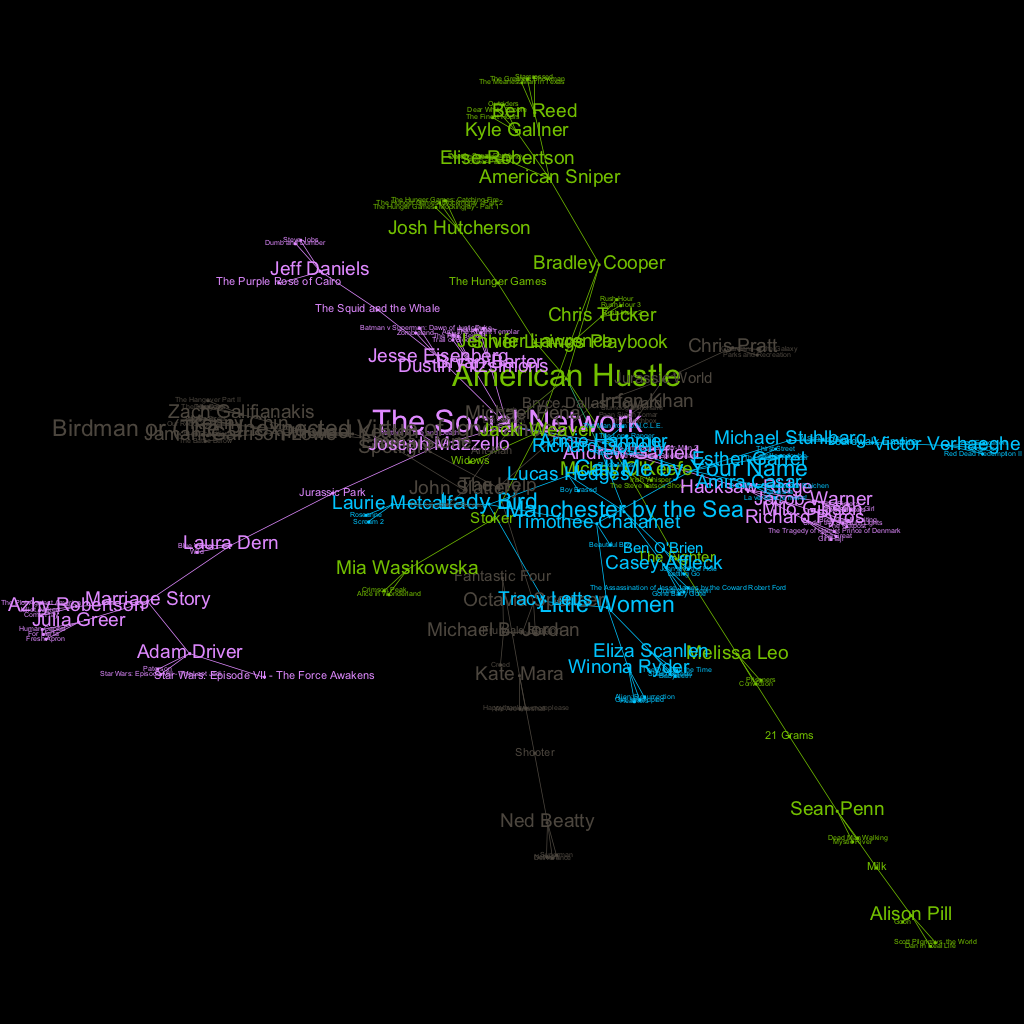

In [42]:
from IPython.display import Image
Image("Network02.png")

## 5. Final Analysis & Storytelling

Movie studios seek to win Academy Awards because they can bring additional business and help with acquiring talent, and the Oscar for Best Picture is the most coveted.

The analysis above attempts to discover similarities between films that have won best picture, while also identifying differences between films that were only nominated. The analysis was focused on films nominated since 2011 in order to avoid shifts in cultural preference that happens over time.

The analysis shows that 91% of Best Picture winners were categorized as dramas. A single winner, The Shape of Water, was not considered a drama; however, that film is effectively a drama. This means 100% of Oscar winners are dramas.

While only dramas have won best picture, this analysis has shown that they do not perform well at the box office. A movie studio that wishes to develop a best picture nominee has to be willing to trade box office results for prestige, which will ultimately bring additional business in the future.

While films rated G, PG, PG-13, and R were all nominated, only films rated R and PG-13 have won best picture during this time period. 82% of winners were rated R, and 18% of winners were rated PG-13. However, R-rated films performed the worst at the box office. A studio executive may think to mitigate the R-rated box office loss by producing a film rated PG-13 instead, but PG-13 films have the lowest critic ratings. Best Picture Winners typically have higher critic ratings, as seen in the sentiment analysis performed above.

Films categorized as adventure and films with a G-rating have the best box office performance. I would suggest an R-rated drama/adventure be developed as a best picture contender, while also developing a G-rated adventure film to mitigate the loss of producing both an R-rated film and a drama.

Based on the topic modeling results, the film could be about any number of topics: a jazz drummer, a family conflict, and a war that involves the British or the French are a few.

Based on the network analysis, I would suggest the movie studio try to hire Viola Davis given her high betweeness centrality. The other two actors with high betweeness centrality have been working in the industry since at least 1986. This is likely why their bteweeness centrality is so high. However, Viola Davis' earliest film credit is from 1996. She is a prolific actor who has already won an Academy Award for Best Supporting Actress.

The word frequency distribution of appropriately cleaned twitter data related to the 2021 Best Picture Nominees shows Nomadland as the most frequently used word. If a film has been nominated for Best Picutre, twitter may be a potential indicator of the film's liklihood to win.

## 6. Next Steps

An analysis of a network of directors, writers, editors, and other workers associated with Oscar Best Picture nominated films should be performed. This could tell a richer story than that of the actor network. The people working on a film may be more important than the actors.

In addition, it would be beneficial to analyze full movie reviews rather than the brief review excerpts on Rotten Tomatoes.

These steps combined with the analysis above would show not only what genre, rating, and topics to consider, but also who should be involved in the film's creation.

(Bonus: Minari was my favorite film this year, which did not win. It was rated PG-13.)